# Задание по машинному обучению ч.2:

 Обучить на данных из 1 задания полносвязную неглубокую нейронную сеть. Построить графики зависимости ошибки на обучающей выборке и тестовой выборках от параметра alpha и от количества нейронов.

## Подключаем необходимые библиотеки

In [1]:
import numpy as np
import os
import pandas as pd
import sklearn
import sklearn.model_selection
import sklearn.metrics

from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Загружаем датасет

In [2]:
df = pd.read_csv("fake_job_postings.csv")

## Повторим обработку данных, проделанную в задании 1:

In [3]:
df=df.drop(['job_id','location','department','salary_range','description','title','company_profile','benefits','requirements'],axis=1)
columns_list=list(df.columns)

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in columns_list:
    if df[i].dtype=='object':
        df[i]=df[i].replace(np.nan,df[i].mode()[0],regex=True)

for i in columns_list:
    if df[i].dtype=='object':
        df[i]=le.fit_transform(df[i])
        
df

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,2,4,1,58,22,0
1,0,1,0,1,6,1,75,7,0
2,0,1,0,1,5,1,58,18,0
3,0,1,0,1,5,1,22,31,0
4,0,1,1,1,5,1,51,16,0
...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,1,22,31,0
17876,0,1,1,1,5,1,61,0,0
17877,0,0,0,1,5,1,58,18,0
17878,0,0,1,0,6,6,48,9,0


## Разбиваем данные на обучающую и тестовую выборки

In [4]:
from sklearn.model_selection import train_test_split
y=df['fraudulent']

X=df.drop(['fraudulent'],axis=1)
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=0,test_size=0.2)

N_test, _ = x_test.shape

## Обучаем классификатор

In [5]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(50,),
    solver='adam',
    activation='relu',
    random_state=3,
    max_iter=500
)

In [6]:
%%time
mlp_model.fit(x_train, y_train)

Wall time: 4.18 s


MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=3)

## Проверяем качество работы классификатора

In [7]:
y_train_prediction = mlp_model.predict(x_train)
y_test_prediction = mlp_model.predict(x_test)

### Точность на обучающей и тестовой выборках:

In [8]:
from sklearn.metrics import accuracy_score
print("Train: ", accuracy_score(y_train, y_train_prediction))
print("Test: ", accuracy_score(y_test, y_test_prediction))

Train:  0.9567253914988815
Test:  0.9633668903803132


### Подбор _гипер_параметров

In [9]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'adam', activation = 'relu', max_iter=1000, random_state = 42)
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(sklearn.metrics.accuracy_score(y_train, y_train_pred))
    test_acc.append(sklearn.metrics.accuracy_score(y_test, y_test_pred))

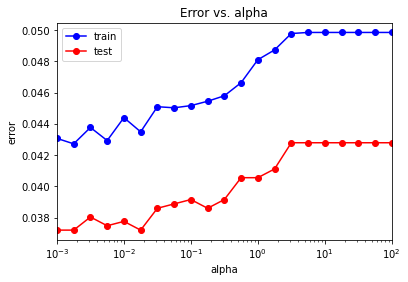

In [10]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

### Рассмотрим как у нас менялась метрика в зависимости от гиперпараметра:

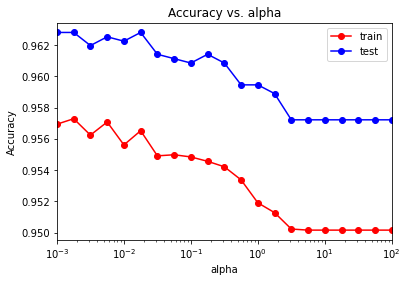

In [11]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

При увеличении параметра регуляризации точность на тренирвоочной выборке уменьшается(при значении параметра больше 1).При оптимальном параметре точность на тестовой и тренировочной выборках максимальна.

### Минимальное значение ошибки:

In [12]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.04271532438478747 0.0371923937360179


### Оптимальное значение alpha:

In [13]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt[0])

0.001


In [14]:
alpha_opt = alpha_opt[0]

## Классификатор при найденном оптимальном значении `alpha`:

### Повторим обучение:

In [15]:
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(50,),
                          solver='adam', activation='relu', random_state=7)
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

### Ошибка на обучающей и тестовой выборке:

In [16]:
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.044043624161073824
0.03747203579418344


### Матрица рассогласования:

In [17]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[3415  126]
 [   8   27]]


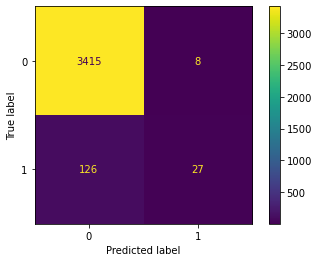

In [18]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, x_test, y_test) 

### Подбор числа нейронов

In [19]:
neuron_count_arr = np.linspace(10, 300, 30).astype(int)
test_err = []
train_err = []
test_acc = []
train_acc = []

for neuron_count in neuron_count_arr:
    mlp_model = MLPClassifier(
        alpha=alpha_opt,
        hidden_layer_sizes=(neuron_count,),
        solver='adam',
        activation='relu',
        max_iter=1000,
        random_state=7
    )
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)

    test_err.append(np.mean(y_test != y_test_pred))
    train_err.append(np.mean(y_train != y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))

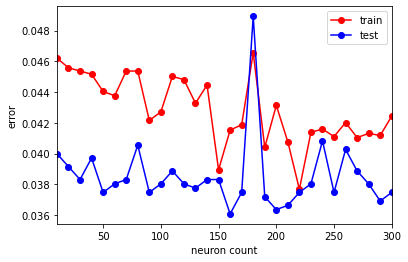

In [20]:
plt.plot(neuron_count_arr, train_err, 'r-o', label='train')
plt.plot(neuron_count_arr, test_err, 'b-o', label='test')
plt.xlim([np.min(neuron_count_arr), np.max(neuron_count_arr)])
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()

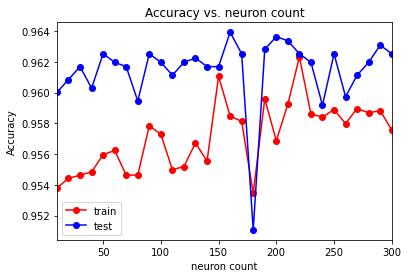

In [21]:
plt.plot(neuron_count_arr, train_acc, 'r-o', label='train')
plt.plot(neuron_count_arr, test_acc, 'b-o', label='test')
plt.xlim([np.min(neuron_count_arr), np.max(neuron_count_arr)])
plt.title('Accuracy vs. neuron count')
plt.xlabel('neuron count')
plt.ylabel('Accuracy')
plt.legend()

In [22]:
min_test_error = np.min(test_err)
neuron_opt = neuron_count_arr[test_err == min_test_error][0]
print('Optimal neuron count:', neuron_opt)

Optimal neuron count: 160


Оптипмальное число нейронов 160, в нем была наилучшая точность и на тренировочной и на тестовой выборке.

### Классифкатор при найденном оптимальном значении числа нейронов и оптимальном `alpha`

In [23]:
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(neuron_opt,),
                          solver='adam', activation='relu', max_iter=1500, random_state=42)
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

### Точность классификатора на обучающей и тестовой выборке:

In [24]:
train_acc = accuracy_score(y_train, y_train_prediction)
test_acc = accuracy_score(y_test, y_test_prediction)
print('Train: ', train_acc)
print('Test: ',test_acc)

Train:  0.9567253914988815
Test:  0.9633668903803132


### Вероятность ошибки классификатора на обучающей и тестовой выборке

In [25]:
print('Train_error: ', 1 - train_acc)
print('Test_error: ', 1 - test_acc)

Train_error:  0.04327460850111853
Test_error:  0.0366331096196868


## Вывод:
### Первоначальный классификатор, созданный без подбора оптимальных параметров, оказался очень точным, поскольку при оптимальном подборе параметров не получилось ощутимо изменить точность.